In [ ]:
# (Kaggle typically already has these; uncomment install lines only if needed)
# !pip install albumentations==1.3.0 opencv-python-headless==4.7.0.72

import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
import albumentations as A

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


# Input dataset mounted by Kaggle when you attach it
INPUT_ROOT = "/kaggle/input/agricultural-crops-image-classification"

# Output path (Kaggle working dir)
OUTPUT_ROOT = "/kaggle/working/agri_prepared"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Per-class synthetic damaged images to generate (total)
PER_CLASS_DAMAGED = 30

# Train/Val/Test split (fractions must sum to 1.0)
SPLIT_RATIOS = {"train": 0.7, "val": 0.15, "test": 0.15}

# Max dimension (resize larger images to this to speed up augmentation)
MAX_DIM = 800

print("Input root exists:", os.path.exists(INPUT_ROOT))
print("Output root:", OUTPUT_ROOT)
print("Per-class damaged:", PER_CLASS_DAMAGED)
print("Split ratios:", SPLIT_RATIOS)


In [3]:
# --- Custom damage helpers (adapted from earlier) ---
def add_spots(img, count=12):
    out = img.copy()
    h,w = out.shape[:2]
    for _ in range(count):
        r = int(np.clip(np.random.normal(loc=min(h,w)*0.03, scale=3), 3, min(h,w)*0.12))
        cx = random.randint(0, w-1)
        cy = random.randint(0, h-1)
        color = (
            int(random.uniform(30, 110)),
            int(random.uniform(20, 80)),
            int(random.uniform(20, 70)),
        )
        cv2.circle(out, (cx, cy), r, color, -1, lineType=cv2.LINE_AA)
    return out

def add_holes(img, num_holes=2):
    out = img.copy()
    h, w = out.shape[:2]
    for _ in range(num_holes):
        hh = int(random.uniform(0.05, 0.25) * h)
        ww = int(random.uniform(0.05, 0.25) * w)
        x = random.randint(0, max(0, w-ww-1))
        y = random.randint(0, max(0, h-hh-1))
        mask = np.zeros((hh, ww, 3), dtype=np.uint8)
        cv2.ellipse(mask, (ww//2, hh//2), (ww//2, hh//3), random.randint(0,360), 0, 360, (255,255,255), -1)
        patch = out[y:y+hh, x:x+ww]
        if patch.shape[0] == hh and patch.shape[1] == ww:
            dark = cv2.addWeighted(patch, 0.25, np.full_like(patch, (30,25,20)), 0.75, 0)
            out[y:y+hh, x:x+ww] = dark
    return out

def add_edge_burn(img):
    h,w = img.shape[:2]
    out = img.copy().astype(np.float32)
    mask = np.zeros((h,w), dtype=np.float32)
    cx, cy = random.randint(0,w-1), random.randint(0,h-1)
    maxr = np.hypot(max(cx, w-cx), max(cy, h-cy))
    for yy in range(h):
        for xx in range(w):
            d = np.hypot(xx-cx, yy-cy)
            mask[yy,xx] = min(1.0, (d/maxr) ** random.uniform(0.9,2.2))
    for c in range(3):
        out[:,:,c] = out[:,:,c] * (1 - 0.6*mask) + 15*mask
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def add_water_inundation(img, severity=0.6):
    out = img.copy().astype(np.float32)
    hsv = cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,1] *= max(0.2, 1 - 0.6*severity)
    out = cv2.cvtColor(np.clip(hsv,0,255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    overlay = out.copy().astype(np.float32)
    alpha = min(0.5, 0.2 + 0.6*severity)
    overlay[:,:] = overlay[:,:] * (1 - alpha) + np.array([100,120,170], dtype=np.float32) * alpha
    blended = cv2.addWeighted(out.astype(np.uint8), 1-alpha, overlay.astype(np.uint8), alpha, 0)
    k = int(1 + severity*6)
    if k % 2 == 0: k += 1
    blended = cv2.GaussianBlur(blended, (k,k), 0)
    return blended

base_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=30, val_shift_limit=20, p=0.6),
    A.GaussianBlur(blur_limit=(3,7), p=0.35),
    A.GaussNoise(var_limit=(10.0, 60.0), p=0.35),
    A.RandomFog(fog_coef_lower=0.02, fog_coef_upper=0.12, p=0.15),
], p=1.0)

def synthesize_damage(img, damage_type=None):
    out = base_transform(image=img)['image']
    severity = 0.0
    types = ['spots','holes','edge_burn','water_inundation','pest']
    if damage_type is None:
        damage_type = random.choice(types)
    if damage_type == 'spots':
        cnt = random.randint(6, 28)
        out = add_spots(out, count=cnt); severity += min(1.0, cnt/30.0) * random.uniform(0.5, 1.0)
    if damage_type in ('holes','pest'):
        nh = random.randint(1,6)
        out = add_holes(out, num_holes=nh); severity += min(1.0, nh/6.0) * random.uniform(0.5, 1.0)
    if damage_type == 'edge_burn':
        out = add_edge_burn(out); severity += random.uniform(0.4, 0.9)
    if damage_type == 'water_inundation':
        sev = random.uniform(0.4, 0.9)
        out = add_water_inundation(out, severity=sev); severity += sev
    severity = float(np.clip(severity, 0.0, 1.0))
    # growth stage synthetic (you can improve by real metadata later)
    growth_stage = random.choices(['early','mid','late'], weights=[0.35,0.45,0.2])[0]
    return out, damage_type, growth_stage, severity

def severity_to_health_score(sev):
    score = (1.0 - sev) * 100.0
    noise = random.uniform(-3,3)
    return round(float(np.clip(score + noise, 0.0, 100.0)), 2)


/tmp/ipykernel_37/16380399.py:66: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 60.0), p=0.35),
/tmp/ipykernel_37/16380399.py:67: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.02, fog_coef_upper=0.12, p=0.15),


In [8]:
# ===== Robust discovery + processing cell (UPDATED: growth_stage + healthy score variability) =====
import os, shutil, random, cv2, numpy as np
from glob import glob
from tqdm.auto import tqdm

# Helper: find all subdirectories under INPUT_ROOT that contain at least one image file
def find_class_dirs(root, exts=(".jpg",".jpeg",".png",".JPG",".JPEG")):
    class_dirs = []
    for dirpath, dirnames, filenames in os.walk(root):
        for ext in exts:
            if any(fname.lower().endswith(ext.lower()) for fname in filenames):
                class_dirs.append(dirpath)
                break
    return sorted(list(set(class_dirs)))

# Discover class directories
all_class_dirs = find_class_dirs(INPUT_ROOT)
print(f"Total class directories found (dirs containing images): {len(all_class_dirs)}")
# If none found at INPUT_ROOT, try one-level deeper (common Kaggle packaging)
if len(all_class_dirs) == 0:
    subdirs = [d for d in glob(os.path.join(INPUT_ROOT, "*")) if os.path.isdir(d)]
    for s in subdirs:
        found = find_class_dirs(s)
        if found:
            all_class_dirs = found
            print("Detected nested structure — using subfolder:", s)
            break

if len(all_class_dirs) == 0:
    raise ValueError(f"No image-containing class directories found under {INPUT_ROOT}. Please check the dataset mount path.")

# Build mapping: class name (basename) -> full path
class_map = {}
for d in all_class_dirs:
    cls_name = os.path.basename(d).strip()
    if cls_name == "" or cls_name.lower() == os.path.basename(INPUT_ROOT).lower():
        cls_name = os.path.basename(os.path.dirname(d)).strip() or f"class_{len(class_map)+1}"
    orig = cls_name
    i = 1
    while cls_name in class_map:
        cls_name = f"{orig}_{i}"; i += 1
    class_map[cls_name] = d

print("Classes discovered and sample counts:")
for cname, path in class_map.items():
    count = sum(len(glob(os.path.join(path, ext))) for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG"))
    print(f" - {cname}: {count} images  (path: {path})")

# Helper to assign random growth stage for originals as well
def random_growth_stage():
    return random.choices(['early','mid','late'], weights=[0.35,0.45,0.2])[0]

# Helper to give healthy images a variable health score between 80 and 100
def healthy_score():
    return round(random.uniform(80.0, 100.0), 2)

# Now process each discovered class directory
rows = []
for cls, src_dir in class_map.items():
    # gather image paths in this class folder
    imgs = []
    for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG"):
        imgs.extend(glob(os.path.join(src_dir, ext)))
    if len(imgs) == 0:
        print(f"Skipping {cls}: no images found in {src_dir}")
        continue

    # Shuffle and split originals according to SPLIT_RATIOS
    random.shuffle(imgs)
    n = len(imgs)
    n_train = int(n * SPLIT_RATIOS['train'])
    n_val = int(n * SPLIT_RATIOS['val'])
    n_test = n - n_train - n_val
    splits = {
        'train': imgs[:n_train],
        'val': imgs[n_train:n_train+n_val],
        'test': imgs[n_train+n_val:],
    }

    # Copy originals and record (now with growth_stage and variable healthy score)
    for split_name, list_imgs in splits.items():
        out_good_dir = os.path.join(OUTPUT_ROOT, split_name, cls, "good")
        os.makedirs(out_good_dir, exist_ok=True)
        for src_path in list_imgs:
            bn = os.path.basename(src_path)
            dst_path = os.path.join(out_good_dir, bn)
            shutil.copy2(src_path, dst_path)
            rows.append({
                "filename": os.path.relpath(dst_path, OUTPUT_ROOT),
                "crop": cls,
                "split": split_name,
                "is_damaged": "no",
                "damage_type": "none",
                "growth_stage": random_growth_stage(),
                "health_score": healthy_score(),
                "source": os.path.relpath(src_path, INPUT_ROOT)
            })

    # Synthesize damaged images per split (preserve ratio)
    per_split_counts = {}
    for k, frac in SPLIT_RATIOS.items():
        per_split_counts[k] = int(round(PER_CLASS_DAMAGED * frac))
    diff = PER_CLASS_DAMAGED - sum(per_split_counts.values())
    keys = ['train','val','test']; idx = 0
    while diff != 0:
        per_split_counts[keys[idx % 3]] += 1 if diff > 0 else -1
        diff = PER_CLASS_DAMAGED - sum(per_split_counts.values()); idx += 1

    for split_name, cnt in per_split_counts.items():
        if cnt <= 0:
            continue
        src_pool = splits[split_name] or imgs  # fallback to full class images if split empty
        out_damaged_dir = os.path.join(OUTPUT_ROOT, split_name, cls, "damaged")
        os.makedirs(out_damaged_dir, exist_ok=True)
        produced = 0; attempts = 0; max_attempts = cnt * 25
        pbar = tqdm(total=cnt, desc=f"{cls} | {split_name}", leave=False)
        while produced < cnt and attempts < max_attempts:
            attempts += 1
            src_img = random.choice(src_pool)
            img = cv2.imread(src_img)
            if img is None:
                continue
            # resize if too large
            h,w = img.shape[:2]
            if max(h,w) > MAX_DIM:
                scale = MAX_DIM / max(h,w)
                img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

            # synthesize damage (reuses synthesize_damage function defined earlier in the notebook)
            damage_type = random.choice(['spots','holes','edge_burn','water_inundation','pest'])
            out_img, dmg_type_applied, growth_stage, severity = synthesize_damage(img, damage_type)
            health_score = severity_to_health_score(severity)

            fname = f"damaged_{produced+1:03d}.jpg"
            dst_path = os.path.join(out_damaged_dir, fname)
            cv2.imwrite(dst_path, out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 92])

            rows.append({
                "filename": os.path.relpath(dst_path, OUTPUT_ROOT),
                "crop": cls,
                "split": split_name,
                "is_damaged": "yes",
                "damage_type": dmg_type_applied,
                "growth_stage": growth_stage,
                "health_score": health_score,
                "source": os.path.relpath(src_img, INPUT_ROOT)
            })
            produced += 1
            pbar.update(1)
        pbar.close()
        print(f"Produced {produced}/{cnt} damaged images for class {cls} in split {split_name}")

# Save CSV
df = pd.DataFrame(rows)
csv_path = os.path.join(OUTPUT_ROOT, "dataset_labels.csv")
df.to_csv(csv_path, index=False)
print("Saved CSV:", csv_path)
print("Total records:", len(df))


Total class directories found (dirs containing images): 30
Classes discovered and sample counts:
 - Cherry: 32 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Cherry)
 - Coffee-plant: 29 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Coffee-plant)
 - Cucumber: 31 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Cucumber)
 - Fox_nut(Makhana): 23 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Fox_nut(Makhana))
 - Lemon: 28 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Lemon)
 - Olive-tree: 30 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Olive-tree)
 - Pearl_millet(bajra): 39 images  (path: /kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Pearl_millet(bajra))
 - Tobacco-plant: 33 images  (path: /kaggle/input/agricultural-cr

Cherry | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Cherry in split train


Cherry | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Cherry in split val


Cherry | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Cherry in split test


Coffee-plant | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Coffee-plant in split train


Coffee-plant | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Coffee-plant in split val


Coffee-plant | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Coffee-plant in split test


Cucumber | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Cucumber in split train


Cucumber | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Cucumber in split val


Cucumber | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Cucumber in split test


Fox_nut(Makhana) | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Fox_nut(Makhana) in split train


Fox_nut(Makhana) | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Fox_nut(Makhana) in split val


Fox_nut(Makhana) | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Fox_nut(Makhana) in split test


Lemon | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Lemon in split train


Lemon | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Lemon in split val


Lemon | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Lemon in split test


Olive-tree | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Olive-tree in split train


Olive-tree | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Olive-tree in split val


Olive-tree | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Olive-tree in split test


Pearl_millet(bajra) | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Pearl_millet(bajra) in split train


Pearl_millet(bajra) | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Pearl_millet(bajra) in split val


Pearl_millet(bajra) | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Pearl_millet(bajra) in split test


Tobacco-plant | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class Tobacco-plant in split train


Tobacco-plant | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Tobacco-plant in split val


Tobacco-plant | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class Tobacco-plant in split test


almond | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class almond in split train


almond | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class almond in split val


almond | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class almond in split test


banana | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class banana in split train


banana | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class banana in split val


banana | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class banana in split test


cardamom | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class cardamom in split train


cardamom | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class cardamom in split val


cardamom | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class cardamom in split test


chilli | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class chilli in split train


chilli | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class chilli in split val


chilli | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class chilli in split test


clove | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class clove in split train


clove | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class clove in split val


clove | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class clove in split test


coconut | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class coconut in split train


coconut | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class coconut in split val


coconut | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class coconut in split test


cotton | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class cotton in split train


cotton | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class cotton in split val


cotton | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class cotton in split test


gram | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class gram in split train


gram | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class gram in split val


gram | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class gram in split test


jowar | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class jowar in split train


jowar | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class jowar in split val


jowar | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class jowar in split test


jute | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class jute in split train


jute | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class jute in split val


jute | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class jute in split test


maize | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class maize in split train


maize | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class maize in split val


maize | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class maize in split test


mustard-oil | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class mustard-oil in split train


mustard-oil | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class mustard-oil in split val


mustard-oil | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class mustard-oil in split test


papaya | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class papaya in split train


papaya | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class papaya in split val


papaya | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class papaya in split test


pineapple | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class pineapple in split train


pineapple | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class pineapple in split val


pineapple | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class pineapple in split test


rice | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class rice in split train


rice | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class rice in split val


rice | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class rice in split test


soyabean | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class soyabean in split train


soyabean | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class soyabean in split val


soyabean | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class soyabean in split test


sugarcane | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class sugarcane in split train


sugarcane | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class sugarcane in split val


sugarcane | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class sugarcane in split test


sunflower | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class sunflower in split train


sunflower | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class sunflower in split val


sunflower | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class sunflower in split test


tea | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class tea in split train


tea | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class tea in split val


tea | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class tea in split test


tomato | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class tomato in split train


tomato | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class tomato in split val


tomato | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class tomato in split test


vigna-radiati(Mung) | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class vigna-radiati(Mung) in split train


vigna-radiati(Mung) | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class vigna-radiati(Mung) in split val


vigna-radiati(Mung) | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class vigna-radiati(Mung) in split test


wheat | train:   0%|          | 0/22 [00:00<?, ?it/s]

Produced 22/22 damaged images for class wheat in split train


wheat | val:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class wheat in split val


wheat | test:   0%|          | 0/4 [00:00<?, ?it/s]

Produced 4/4 damaged images for class wheat in split test
Saved CSV: /kaggle/working/agri_prepared/dataset_labels.csv
Total records: 1729


In [9]:
import os
import pandas as pd
import numpy as np

OUTPUT_ROOT = "/kaggle/working/agri_prepared"   # update if different
csv_in = os.path.join(OUTPUT_ROOT, "dataset_labels.csv")
csv_out = os.path.join(OUTPUT_ROOT, "dataset_labels_with_severity.csv")

if not os.path.exists(csv_in):
    raise FileNotFoundError(f"CSV not found: {csv_in}")

df = pd.read_csv(csv_in)

# Map health_score -> severity_level
# Interpretation:
# - For originals (is_damaged == 'no') mark as 'healthy'
# - For damaged: health_score high -> mild damage, medium -> moderate, low -> severe
def health_to_severity(row):
    try:
        hs = float(row.get("health_score", np.nan))
    except:
        return "unknown"
    if str(row.get("is_damaged","")).lower() in ("no","false","0"):
        return "healthy"
    # thresholds (tunable):
    # health_score >= 66 -> mild
    # 33 <= health_score < 66 -> moderate
    # health_score < 33 -> severe
    if hs >= 66.0:
        return "mild"
    elif hs >= 33.0:
        return "moderate"
    else:
        return "severe"

df["severity_level"] = df.apply(health_to_severity, axis=1)

# Save new CSV
df.to_csv(csv_out, index=False)
print("Saved:", csv_out)
df["severity_level"].value_counts(dropna=False)


Saved: /kaggle/working/agri_prepared/dataset_labels_with_severity.csv


severity_level
healthy     829
moderate    439
severe      279
mild        182
Name: count, dtype: int64

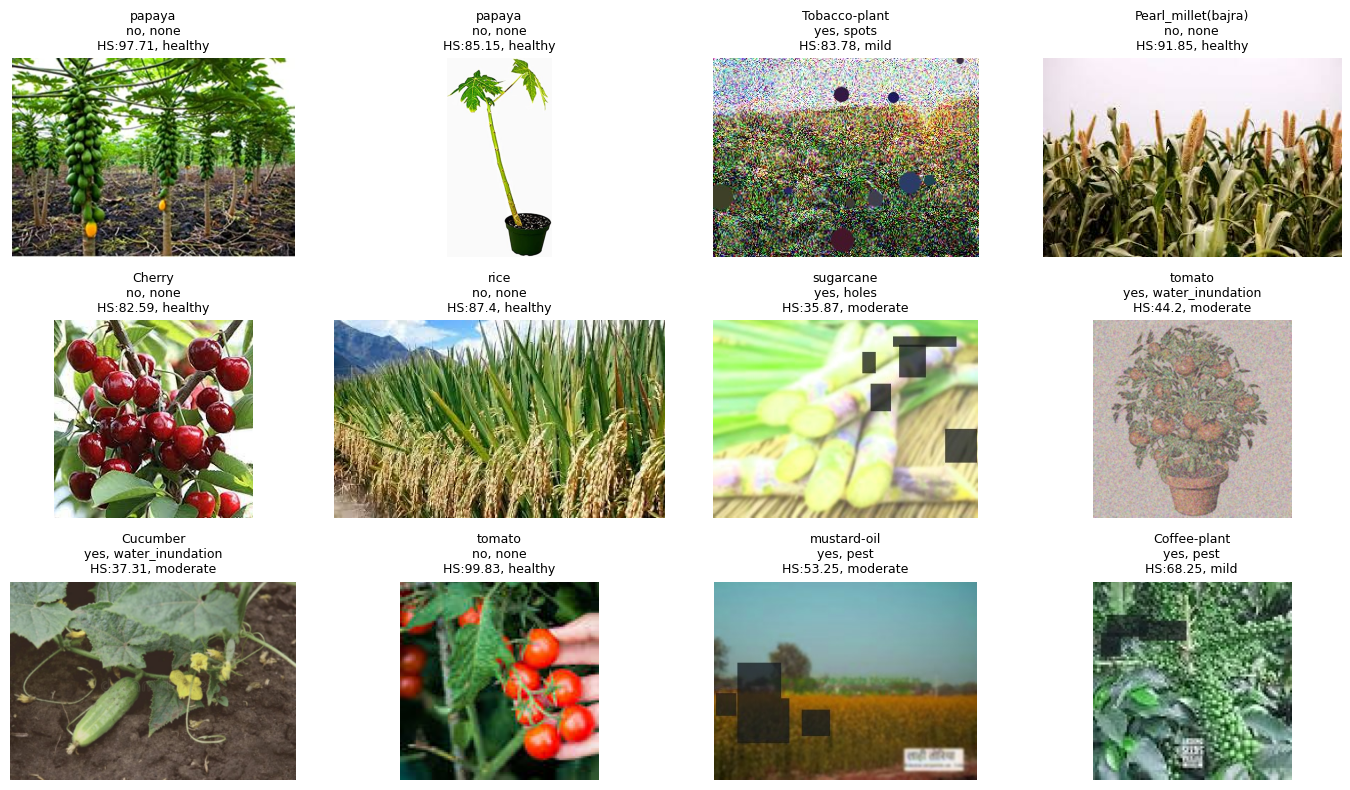

In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import pandas as pd
OUTPUT_ROOT = "/kaggle/working/agri_prepared"  # adjust if different
csv_path = os.path.join(OUTPUT_ROOT, "dataset_labels_with_severity.csv")
if not os.path.exists(csv_path):
    csv_path = os.path.join(OUTPUT_ROOT, "dataset_labels.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError("No CSV found. Run generation first or update OUTPUT_ROOT path.")

df = pd.read_csv(csv_path)
# sample up to 12 images stratified by is_damaged to show both kinds if available
sample_size = min(12, len(df))
# try to pick 6 damaged + 6 not if possible
dam = df[df["is_damaged"].astype(str).str.lower() == "yes"]
not_dam = df[df["is_damaged"].astype(str).str.lower() != "yes"]

samples = []
samples.extend(dam.sample(min(len(dam), sample_size//2), random_state=42).to_dict('records'))
samples.extend(not_dam.sample(min(len(not_dam), sample_size - len(samples)), random_state=43).to_dict('records'))
if len(samples) < sample_size:
    remain = df.sample(sample_size - len(samples), random_state=44).to_dict('records')
    samples.extend(remain)

random.shuffle(samples)
plt.figure(figsize=(14,8))
for i,row in enumerate(samples):
    imgp = os.path.join(OUTPUT_ROOT, row['filename'])
    if not os.path.exists(imgp):
        # sometimes filename stored with slightly different root - try full path
        alt = os.path.join(OUTPUT_ROOT, row.get('filename',''))
        if os.path.exists(alt):
            imgp = alt
        else:
            print("Missing:", row['filename']); continue
    img = cv2.imread(imgp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(3,4,i+1)
    plt.imshow(img); plt.axis('off')
    title = f"{row.get('crop','')}\n{row.get('is_damaged','')}, {row.get('damage_type','')}\nHS:{row.get('health_score','')}, {row.get('severity_level','')}"
    plt.title(title, fontsize=9)
plt.tight_layout()


In [11]:
# Kaggle usually has these; uncomment pip lines only if needed.
# !pip install timm
# !pip install torchmetrics

import os
import random
from glob import glob
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import timm    # optional model zoo
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
import torch.nn.functional as F


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [14]:
# Paths
OUTPUT_ROOT = "/kaggle/working/agri_prepared"   # where dataset_labels*.csv and images are
CSV_NAME = "dataset_labels_with_severity.csv"  # if not found, will fallback
if not os.path.exists(os.path.join(OUTPUT_ROOT, CSV_NAME)):
    if os.path.exists(os.path.join(OUTPUT_ROOT, "dataset_labels.csv")):
        CSV_NAME = "dataset_labels.csv"

CSV_PATH = os.path.join(OUTPUT_ROOT, CSV_NAME)
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"

# Model / training config
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 12
LR = 2e-4
WEIGHT_DECAY = 1e-5
BACKBONE = "resnet50"  # alternatives: resnet34, swin_base (via timm)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4

# Loss weights (adjust if some tasks are more important)
W_CROP = 1.0
W_DAMAGED = 1.0
W_GROWTH = 0.7
W_SEVERITY = 0.7
W_HEALTH = 1.0   # regression MSE weight

print("Using device:", DEVICE)
print("CSV:", CSV_PATH)


Using device: cuda
CSV: /kaggle/working/agri_prepared/dataset_labels_with_severity.csv


In [15]:
df = pd.read_csv(CSV_PATH)
# Show a few rows
display(df.head())

# Filter malformed rows
df = df.dropna(subset=["filename","crop","is_damaged","growth_stage","health_score","severity_level"])
df.reset_index(drop=True, inplace=True)

# Make sure file paths exist - prefix OUTPUT_ROOT if filenames are relative
def resolve_path(p):
    if os.path.isabs(p) and os.path.exists(p):
        return p
    candidate = os.path.join(OUTPUT_ROOT, p)
    if os.path.exists(candidate):
        return candidate
    # try with leading './' fallback
    candidate2 = os.path.join(OUTPUT_ROOT, p.lstrip("./"))
    if os.path.exists(candidate2):
        return candidate2
    return p  # leave as-is; will likely error when loading

df["fullpath"] = df["filename"].apply(resolve_path)
missing = df[~df["fullpath"].apply(os.path.exists)]
if len(missing) > 0:
    print("Warning: some image files were not found. Examples:")
    display(missing.head())
    # Optionally drop missing
    df = df[df["fullpath"].apply(os.path.exists)].reset_index(drop=True)

# Encode crop types
le_crop = LabelEncoder()
df["crop_label"] = le_crop.fit_transform(df["crop"])
num_crops = len(le_crop.classes_)
print("Crops:", num_crops, le_crop.classes_)

# Binary damaged label -> 0/1
df["is_damaged_label"] = df["is_damaged"].astype(str).str.lower().isin(["yes","true","1"]).astype(int)

# growth_stage to labels (early/mid/late)
le_stage = LabelEncoder()
df["growth_stage_label"] = le_stage.fit_transform(df["growth_stage"])
print("Growth stage classes:", le_stage.classes_)

# severity_level to labels (healthy/mild/moderate/severe)
le_severity = LabelEncoder()
df["severity_label"] = le_severity.fit_transform(df["severity_level"])
print("Severity classes:", le_severity.classes_)

# health_score numeric to float
df["health_score"] = df["health_score"].astype(float)

# Show label distribution
print(df.groupby("split").size())
print(df["crop"].value_counts().head())


,filename,crop,split,is_damaged,damage_type,growth_stage,health_score,source,severity_level
0,train/Cherry/good/image21.jpeg,Cherry,train,no,none,mid,92.73,Agricultural-crops/Cherry/image21.jpeg,healthy
1,train/Cherry/good/images41.jpg,Cherry,train,no,none,mid,86.28,Agricultural-crops/Cherry/images41.jpg,healthy
2,train/Cherry/good/image22.jpeg,Cherry,train,no,none,mid,91.97,Agricultural-crops/Cherry/image22.jpeg,healthy
3,train/Cherry/good/image30.jpeg,Cherry,train,no,none,early,99.64,Agricultural-crops/Cherry/image30.jpeg,healthy
4,train/Cherry/good/images25.jpg,Cherry,train,no,none,mid,86.26,Agricultural-crops/Cherry/images25.jpg,healthy


Crops: 30 ['Cherry' 'Coffee-plant' 'Cucumber' 'Fox_nut(Makhana)' 'Lemon'
 'Olive-tree' 'Pearl_millet(bajra)' 'Tobacco-plant' 'almond' 'banana'
 'cardamom' 'chilli' 'clove' 'coconut' 'cotton' 'gram' 'jowar' 'jute'
 'maize' 'mustard-oil' 'papaya' 'pineapple' 'rice' 'soyabean' 'sugarcane'
 'sunflower' 'tea' 'tomato' 'vigna-radiati(Mung)' 'wheat']
Growth stage classes: ['early' 'late' 'mid']
Severity classes: ['healthy' 'mild' 'moderate' 'severe']
split
test      272
train    1229
val       228
dtype: int64
crop
Pearl_millet(bajra)    69
Tobacco-plant          63
Cherry                 62
cotton                 62
Cucumber               61
Name: count, dtype: int64


In [16]:
# Transforms
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class AgriDataset(Dataset):
    def __init__(self, df, split="train", transforms=None):
        self.df = df[df["split"]==split].reset_index(drop=True)
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["fullpath"]
        img = Image.open(path).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        crop = int(row["crop_label"])
        is_damaged = float(row["is_damaged_label"])  # use float for BCE
        growth = int(row["growth_stage_label"])
        severity = int(row["severity_label"])
        health = float(row["health_score"]) / 100.0  # normalize 0-1 for regression
        return {
            "image": img,
            "crop": torch.tensor(crop, dtype=torch.long),
            "is_damaged": torch.tensor(is_damaged, dtype=torch.float32),
            "growth": torch.tensor(growth, dtype=torch.long),
            "severity": torch.tensor(severity, dtype=torch.long),
            "health": torch.tensor(health, dtype=torch.float32),
        }

# Create dataset & dataloaders
train_ds = AgriDataset(df, split="train", transforms=train_transforms)
val_ds = AgriDataset(df, split="val", transforms=val_transforms)
test_ds = AgriDataset(df, split="test", transforms=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))


Train/Val/Test sizes: 1229 228 272


In [17]:
class MultiHeadResNet(nn.Module):
    def __init__(self, backbone_name="resnet50", pretrained=True, num_crops=num_crops, dropout=0.4, embed_dim=1024):
        super().__init__()
        # Use torchvision ResNet or timm
        if backbone_name.startswith("resnet"):
            model = getattr(models, backbone_name)(pretrained=pretrained)
            # remove fc
            in_features = model.fc.in_features
            model.fc = nn.Identity()
            self.backbone = model
            feat_dim = in_features
        else:
            # fallback to timm model
            self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')
            feat_dim = self.backbone.num_features

        # Shared projection
        self.project = nn.Sequential(
            nn.Linear(feat_dim, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Heads
        self.crop_head = nn.Linear(embed_dim, num_crops)            # cross entropy
        self.damaged_head = nn.Linear(embed_dim, 1)                 # BCEWithLogits
        self.growth_head = nn.Linear(embed_dim, len(le_stage.classes_))   # CE
        self.severity_head = nn.Linear(embed_dim, len(le_severity.classes_)) # CE
        self.health_head = nn.Linear(embed_dim, 1)                  # regression output (0-1)

    def forward(self, x):
        # backbone
        feats = self.backbone(x)
        if feats.ndim == 4:
            feats = feats.flatten(1)
        proj = self.project(feats)
        out_crop = self.crop_head(proj)
        out_damaged = self.damaged_head(proj).squeeze(1)
        out_growth = self.growth_head(proj)
        out_severity = self.severity_head(proj)
        out_health = self.health_head(proj).squeeze(1)
        return {
            "crop": out_crop,
            "is_damaged": out_damaged,
            "growth": out_growth,
            "severity": out_severity,
            "health": out_health
        }

model = MultiHeadResNet(backbone_name=BACKBONE, pretrained=True).to(DEVICE)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


MultiHeadResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [18]:
# Loss functions
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()
mse_loss = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# optional scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

def compute_loss(preds, targets):
    loss_crop = ce_loss(preds["crop"], targets["crop"])
    loss_damaged = bce_loss(preds["is_damaged"], targets["is_damaged"])
    loss_growth = ce_loss(preds["growth"], targets["growth"])
    loss_severity = ce_loss(preds["severity"], targets["severity"])
    loss_health = mse_loss(preds["health"], targets["health"])
    total = (W_CROP*loss_crop + W_DAMAGED*loss_damaged + W_GROWTH*loss_growth +
             W_SEVERITY*loss_severity + W_HEALTH*loss_health)
    return total, {
        "loss_crop": loss_crop.item(),
        "loss_damaged": loss_damaged.item(),
        "loss_growth": loss_growth.item(),
        "loss_severity": loss_severity.item(),
        "loss_health": loss_health.item()
    }


In [19]:
def evaluate(loader):
    model.eval()
    stats = {"crop_preds": [], "crop_tg": [],
             "dam_preds": [], "dam_tg": [],
             "growth_preds": [], "growth_tg": [],
             "sev_preds": [], "sev_tg": [],
             "health_preds": [], "health_tg": []}
    losses = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch["image"].to(DEVICE)
            targets = {
                "crop": batch["crop"].to(DEVICE),
                "is_damaged": batch["is_damaged"].to(DEVICE),
                "growth": batch["growth"].to(DEVICE),
                "severity": batch["severity"].to(DEVICE),
                "health": batch["health"].to(DEVICE)
            }
            preds = model(imgs)
            loss, loss_breakdown = compute_loss(preds, targets)
            losses.append(loss.item())

            # predictions for metrics
            stats["crop_preds"].extend(torch.argmax(preds["crop"], dim=1).cpu().numpy().tolist())
            stats["crop_tg"].extend(targets["crop"].cpu().numpy().tolist())

            stats["dam_preds"].extend((torch.sigmoid(preds["is_damaged"])>0.5).cpu().numpy().astype(int).tolist())
            stats["dam_tg"].extend(targets["is_damaged"].cpu().numpy().astype(int).tolist())

            stats["growth_preds"].extend(torch.argmax(preds["growth"], dim=1).cpu().numpy().tolist())
            stats["growth_tg"].extend(targets["growth"].cpu().numpy().tolist())

            stats["sev_preds"].extend(torch.argmax(preds["severity"], dim=1).cpu().numpy().tolist())
            stats["sev_tg"].extend(targets["severity"].cpu().numpy().tolist())

            stats["health_preds"].extend((preds["health"].cpu().numpy().tolist()))
            stats["health_tg"].extend(targets["health"].cpu().numpy().tolist())

    # compute metrics
    out = {}
    out["loss"] = np.mean(losses) if losses else 0.0
    out["crop_acc"] = accuracy_score(stats["crop_tg"], stats["crop_preds"]) if len(stats["crop_tg"])>0 else 0
    out["dam_f1"] = f1_score(stats["dam_tg"], stats["dam_preds"], zero_division=0)
    out["growth_acc"] = accuracy_score(stats["growth_tg"], stats["growth_preds"])
    out["sev_acc"] = accuracy_score(stats["sev_tg"], stats["sev_preds"])
    # health RMSE (remember health in targets was normalized 0-1)
    out["health_rmse"] = math.sqrt(mean_squared_error(stats["health_tg"], stats["health_preds"])) if len(stats["health_tg"])>0 else 0
    return out

best_val = 1e9
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
    for batch in pbar:
        imgs = batch["image"].to(DEVICE)
        targets = {
            "crop": batch["crop"].to(DEVICE),
            "is_damaged": batch["is_damaged"].to(DEVICE),
            "growth": batch["growth"].to(DEVICE),
            "severity": batch["severity"].to(DEVICE),
            "health": batch["health"].to(DEVICE)
        }
        preds = model(imgs)
        loss, loss_breakdown = compute_loss(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{np.mean(running_losses):.4f}"})
    scheduler.step()

    val_stats = evaluate(val_loader)
    print(f"Epoch {epoch}: TrainLoss={np.mean(running_losses):.4f} | ValLoss={val_stats['loss']:.4f} | CropAcc={val_stats['crop_acc']:.3f} | DamF1={val_stats['dam_f1']:.3f} | GrowthAcc={val_stats['growth_acc']:.3f} | SevAcc={val_stats['sev_acc']:.3f} | HealthRMSE={val_stats['health_rmse']:.4f}")

    # save best model by val loss
    if val_stats['loss'] < best_val:
        best_val = val_stats['loss']
        torch.save({
            "model_state": model.state_dict(),
            "le_crop": le_crop,
            "le_stage": le_stage,
            "le_severity": le_severity
        }, os.path.join(OUTPUT_ROOT, "best_multitask_model.pth"))
        print("Saved best model.")


Epoch 1/12: 100%|██████████| 39/39 [00:14<00:00,  2.63it/s, loss=5.0378]


Epoch 1: TrainLoss=5.0378 | ValLoss=4.2482 | CropAcc=0.377 | DamF1=0.897 | GrowthAcc=0.430 | SevAcc=0.649 | HealthRMSE=0.5379
Saved best model.


Epoch 2/12: 100%|██████████| 39/39 [00:12<00:00,  3.20it/s, loss=3.4717]


Epoch 2: TrainLoss=3.4717 | ValLoss=3.6675 | CropAcc=0.526 | DamF1=0.912 | GrowthAcc=0.382 | SevAcc=0.658 | HealthRMSE=0.3811
Saved best model.


Epoch 3/12: 100%|██████████| 39/39 [00:12<00:00,  3.18it/s, loss=2.6473]


Epoch 3: TrainLoss=2.6473 | ValLoss=3.2168 | CropAcc=0.614 | DamF1=0.926 | GrowthAcc=0.487 | SevAcc=0.680 | HealthRMSE=0.3102
Saved best model.


Epoch 4/12: 100%|██████████| 39/39 [00:12<00:00,  3.12it/s, loss=2.1339]


Epoch 4: TrainLoss=2.1339 | ValLoss=3.1209 | CropAcc=0.636 | DamF1=0.940 | GrowthAcc=0.417 | SevAcc=0.689 | HealthRMSE=0.3009
Saved best model.


Epoch 5/12: 100%|██████████| 39/39 [00:12<00:00,  3.02it/s, loss=1.7745]


Epoch 5: TrainLoss=1.7745 | ValLoss=3.0354 | CropAcc=0.667 | DamF1=0.929 | GrowthAcc=0.421 | SevAcc=0.689 | HealthRMSE=0.2389
Saved best model.


Epoch 6/12: 100%|██████████| 39/39 [00:13<00:00,  2.98it/s, loss=1.4781]


Epoch 6: TrainLoss=1.4781 | ValLoss=3.1632 | CropAcc=0.706 | DamF1=0.910 | GrowthAcc=0.390 | SevAcc=0.680 | HealthRMSE=0.2292


Epoch 7/12: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s, loss=1.2932]


Epoch 7: TrainLoss=1.2932 | ValLoss=3.0243 | CropAcc=0.667 | DamF1=0.943 | GrowthAcc=0.417 | SevAcc=0.693 | HealthRMSE=0.2246
Saved best model.


Epoch 8/12: 100%|██████████| 39/39 [00:13<00:00,  2.81it/s, loss=1.0912]


Epoch 8: TrainLoss=1.0912 | ValLoss=3.0963 | CropAcc=0.711 | DamF1=0.920 | GrowthAcc=0.355 | SevAcc=0.693 | HealthRMSE=0.2108


Epoch 9/12: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s, loss=0.9370]


Epoch 9: TrainLoss=0.9370 | ValLoss=2.9430 | CropAcc=0.719 | DamF1=0.939 | GrowthAcc=0.408 | SevAcc=0.693 | HealthRMSE=0.2111
Saved best model.


Epoch 10/12: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s, loss=0.8159]


Epoch 10: TrainLoss=0.8159 | ValLoss=3.0160 | CropAcc=0.715 | DamF1=0.920 | GrowthAcc=0.382 | SevAcc=0.702 | HealthRMSE=0.2010


Epoch 11/12: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s, loss=0.7586]


Epoch 11: TrainLoss=0.7586 | ValLoss=2.9934 | CropAcc=0.724 | DamF1=0.934 | GrowthAcc=0.390 | SevAcc=0.711 | HealthRMSE=0.1925


Epoch 12/12: 100%|██████████| 39/39 [00:13<00:00,  2.81it/s, loss=0.7145]


Epoch 12: TrainLoss=0.7145 | ValLoss=3.0425 | CropAcc=0.728 | DamF1=0.924 | GrowthAcc=0.377 | SevAcc=0.706 | HealthRMSE=0.1930


In [22]:
# Load best model (optional)
ckpt = torch.load(os.path.join(OUTPUT_ROOT, "best_multitask_model.pth"), map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.to(DEVICE)
model.eval()

test_stats = evaluate(test_loader)
print("Test stats:", test_stats)

# Inference helper for single image path (returns decoded labels)
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    x = val_transforms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = model(x)
    crop_idx = int(torch.argmax(preds["crop"], dim=1).cpu().item())
    crop_name = le_crop.inverse_transform([crop_idx])[0]
    damaged_prob = float(torch.sigmoid(preds["is_damaged"]).cpu().item())
    damaged = damaged_prob > 0.5
    growth_idx = int(torch.argmax(preds["growth"], dim=1).cpu().item())
    growth_name = le_stage.inverse_transform([growth_idx])[0]
    sev_idx = int(torch.argmax(preds["severity"], dim=1).cpu().item())
    sev_name = le_severity.inverse_transform([sev_idx])[0]
    health = float(preds["health"].cpu().item()) * 100.0
    return {
        "crop": crop_name,
        "is_damaged_prob": damaged_prob,
        "is_damaged": bool(damaged),
        "growth_stage": growth_name,
        "severity_level": sev_name,
        "health_score": round(health,2)
    }

# quick example on a random test image
sample_row = df[df['split']=='test'].sample(1).iloc[0]
print(sample_row['fullpath'])
print(predict_image(sample_row['fullpath']))


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL sklearn.preprocessing._label.LabelEncoder was not an allowed global by default. Please use `torch.serialization.add_safe_globals([LabelEncoder])` or the `torch.serialization.safe_globals([LabelEncoder])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [23]:
import torch
from sklearn.preprocessing import LabelEncoder
import os

ckpt_path = os.path.join(OUTPUT_ROOT, "best_multitask_model.pth")

# Allowlist LabelEncoder so it can be unpickled (only do this for trusted files)
torch.serialization.add_safe_globals([LabelEncoder])

ckpt = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)  # weights_only=False -> load full dict
# ckpt should be a dict like {"model_state":..., "le_crop":..., ...}
print("Keys in checkpoint:", list(ckpt.keys()))

# Now load model weights into your model (ensure model architecture matches)
model.load_state_dict(ckpt["model_state"])
model.to(DEVICE)
model.eval()

# Recover label encoders if needed
le_crop = ckpt.get("le_crop", None)
le_stage = ckpt.get("le_stage", None)
le_severity = ckpt.get("le_severity", None)
print("Loaded label encoders:", bool(le_crop), bool(le_stage), bool(le_severity))


Keys in checkpoint: ['model_state', 'le_crop', 'le_stage', 'le_severity']
Loaded label encoders: True True True


In [24]:
# In your training script (when you still have the model in memory):
torch.save({"model_state": model.state_dict()}, "/kaggle/working/clean_model.pth")
# Then transfer / load only that file on inference side:
ck = torch.load("/kaggle/working/clean_model.pth", map_location=DEVICE)
model.load_state_dict(ck["model_state"])


<All keys matched successfully>

In [25]:
import torch, os
clean_ckpt_path = os.path.join(OUTPUT_ROOT, "clean_model_state.pth")
torch.save({"model_state": model.state_dict()}, clean_ckpt_path)
print("Saved clean checkpoint to:", clean_ckpt_path)


Saved clean checkpoint to: /kaggle/working/agri_prepared/clean_model_state.pth


In [26]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

model.eval()
pred_rows = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference on test"):
        imgs = batch["image"].to(DEVICE)
        preds = model(imgs)
        # crop
        crop_logits = preds["crop"]
        crop_probs = torch.softmax(crop_logits, dim=1).cpu().numpy()
        crop_preds = np.argmax(crop_probs, axis=1)
        # damaged
        dam_logits = preds["is_damaged"]
        dam_probs = torch.sigmoid(dam_logits).cpu().numpy()
        dam_preds = (dam_probs > 0.5).astype(int)
        # growth
        growth_logits = preds["growth"]
        growth_probs = torch.softmax(growth_logits, dim=1).cpu().numpy()
        growth_preds = np.argmax(growth_probs, axis=1)
        # severity
        sev_logits = preds["severity"]
        sev_probs = torch.softmax(sev_logits, dim=1).cpu().numpy()
        sev_preds = np.argmax(sev_probs, axis=1)
        # health
        health_preds = preds["health"].cpu().numpy() * 100.0  # convert back 0-100

        # iterate examples
        batch_size = imgs.size(0)
        for i in range(batch_size):
            row = {
                "filename": batch["image"].shape,  # placeholder; replace below
                "crop_pred_idx": int(crop_preds[i]),
                "crop_pred": le_crop.inverse_transform([int(crop_preds[i])])[0],
                "crop_prob": float(crop_probs[i, int(crop_preds[i])]),
                "is_damaged_prob": float(dam_probs[i]),
                "is_damaged_pred": int(dam_preds[i]),
                "growth_pred_idx": int(growth_preds[i]),
                "growth_pred": le_stage.inverse_transform([int(growth_preds[i])])[0],
                "growth_prob": float(growth_probs[i, int(growth_preds[i])]),
                "severity_pred_idx": int(sev_preds[i]),
                "severity_pred": le_severity.inverse_transform([int(sev_preds[i])])[0],
                "severity_prob": float(sev_probs[i, int(sev_preds[i])]),
                "health_pred": float(round(health_preds[i], 2)),
                "health_pred_norm": float(preds["health"].cpu().numpy()[i])
            }
            # recover filename from dataset — test_loader.batch_size may not give original filename directly,
            # so extract from dataset using indices if your DataLoader/dataset returns a path.
            # If your Dataset returns filename in batch, use that. Otherwise we use placeholder.
            # Try to fetch the corresponding index from the underlying dataset if available:
            try:
                # if batch has 'index' or 'path' return included in dataset __getitem__
                if "path" in batch:
                    row["filename"] = batch["path"][i]
                elif "filename" in batch:
                    row["filename"] = batch["filename"][i]
                else:
                    # fallback: leave blank or fill with idx location in test dataset
                    row["filename"] = ""
            except:
                row["filename"] = ""
            pred_rows.append(row)

# If your DataLoader/Dataset returned filenames in the batch, they'll be preserved.
# Convert to dataframe
pred_df = pd.DataFrame(pred_rows)
out_csv = os.path.join(OUTPUT_ROOT, "test_predictions.csv")
pred_df.to_csv(out_csv, index=False)
print("Saved predictions to:", out_csv)
display(pred_df.head())


Inference on test: 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]

Saved predictions to: /kaggle/working/agri_prepared/test_predictions.csv


,filename,crop_pred_idx,crop_pred,crop_prob,is_damaged_prob,is_damaged_pred,growth_pred_idx,growth_pred,growth_prob,severity_pred_idx,severity_pred,severity_prob,health_pred,health_pred_norm
0,,0,Cherry,0.783126,0.014074,0,2,mid,0.411901,0,healthy,0.989431,107.269997,1.072699
1,,0,Cherry,0.977878,0.160018,0,2,mid,0.654220,0,healthy,0.896064,84.870003,0.848720
2,,0,Cherry,0.937342,0.003088,0,0,early,0.413564,0,healthy,0.997783,89.690002,0.896854
3,,0,Cherry,0.898762,0.033714,0,2,mid,0.750283,0,healthy,0.971070,76.059998,0.760649
4,,1,Coffee-plant,0.528754,0.168596,0,0,early,0.512431,0,healthy,0.867613,68.389999,0.683941


=== VAL SET METRICS ===
Crop Accuracy       : 0.719
Damaged F1 / Acc    : 0.939 / 0.939
Growth Stage Acc    : 0.408
Severity Level Acc  : 0.693
Health Score RMSE   : 0.2111 (0-1 scale -> ~21.11 pts)
=== TEST SET METRICS ===
Crop Accuracy       : 0.783
Damaged F1 / Acc    : 0.949 / 0.956
Growth Stage Acc    : 0.393
Severity Level Acc  : 0.787
Health Score RMSE   : 0.2017 (0-1 scale -> ~20.17 pts)


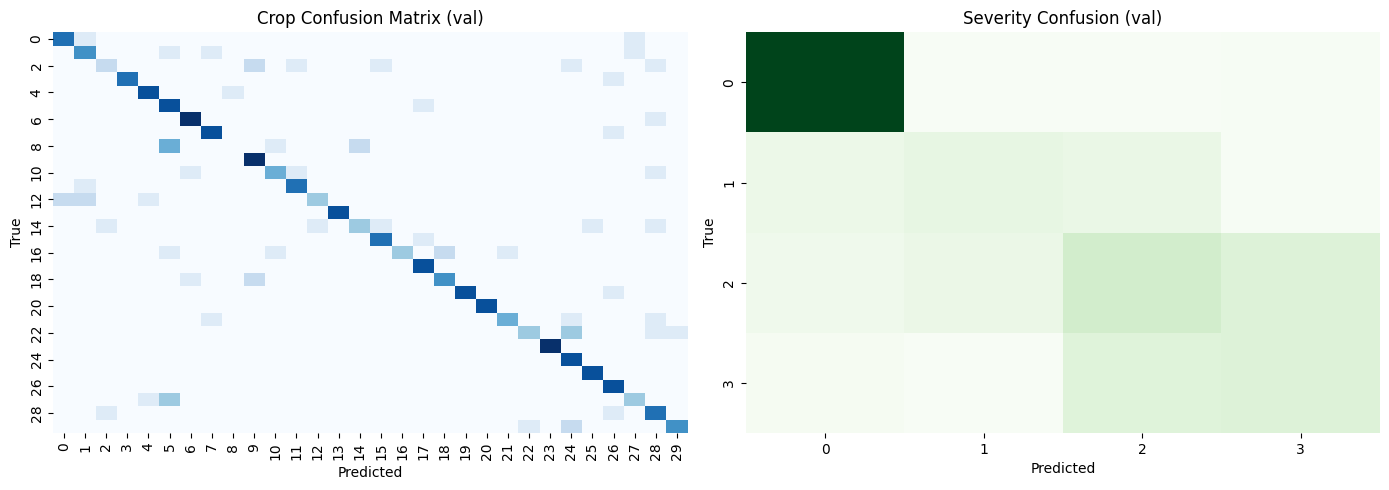

In [27]:
import torch, numpy as np, pandas as pd, math, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, classification_report, confusion_matrix

# ---------- load checkpoint ----------
ckpt_path = os.path.join(OUTPUT_ROOT, "best_multitask_model.pth")
torch.serialization.add_safe_globals([LabelEncoder])
ckpt = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt["model_state"])
model.to(DEVICE)
model.eval()

# ---------- evaluate function ----------
def evaluate_full(loader, name="test"):
    model.eval()
    y_crop_t, y_crop_p = [], []
    y_dam_t, y_dam_p = [], []
    y_growth_t, y_growth_p = [], []
    y_sev_t, y_sev_p = [], []
    y_health_t, y_health_p = [], []
    losses = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch["image"].to(DEVICE)
            tg = {k:v.to(DEVICE) for k,v in batch.items() if k!="image"}
            pr = model(imgs)
            y_crop_t.extend(tg["crop"].cpu().numpy())
            y_crop_p.extend(torch.argmax(pr["crop"],1).cpu().numpy())
            y_dam_t.extend(tg["is_damaged"].cpu().numpy())
            y_dam_p.extend((torch.sigmoid(pr["is_damaged"])>0.5).cpu().numpy())
            y_growth_t.extend(tg["growth"].cpu().numpy())
            y_growth_p.extend(torch.argmax(pr["growth"],1).cpu().numpy())
            y_sev_t.extend(tg["severity"].cpu().numpy())
            y_sev_p.extend(torch.argmax(pr["severity"],1).cpu().numpy())
            y_health_t.extend(tg["health"].cpu().numpy())
            y_health_p.extend(pr["health"].cpu().numpy())
    # compute metrics
    crop_acc = accuracy_score(y_crop_t, y_crop_p)
    dam_acc  = accuracy_score(y_dam_t, y_dam_p)
    dam_f1   = f1_score(y_dam_t, y_dam_p, zero_division=0)
    growth_acc = accuracy_score(y_growth_t, y_growth_p)
    sev_acc = accuracy_score(y_sev_t, y_sev_p)
    rmse = math.sqrt(mean_squared_error(y_health_t, y_health_p))
    print(f"=== {name.upper()} SET METRICS ===")
    print(f"Crop Accuracy       : {crop_acc:.3f}")
    print(f"Damaged F1 / Acc    : {dam_f1:.3f} / {dam_acc:.3f}")
    print(f"Growth Stage Acc    : {growth_acc:.3f}")
    print(f"Severity Level Acc  : {sev_acc:.3f}")
    print(f"Health Score RMSE   : {rmse:.4f} (0-1 scale -> ~{rmse*100:.2f} pts)")
    return dict(crop_acc=crop_acc, dam_f1=dam_f1, dam_acc=dam_acc,
                growth_acc=growth_acc, sev_acc=sev_acc, rmse=rmse,
                y_crop_t=y_crop_t, y_crop_p=y_crop_p,
                y_sev_t=y_sev_t, y_sev_p=y_sev_p)

# ---------- run on val & test ----------
val_stats = evaluate_full(val_loader, "val")
test_stats = evaluate_full(test_loader, "test")

# ---------- confusion matrices ----------
fig, axes = plt.subplots(1, 2, figsize=(14,5))
cm_crop = confusion_matrix(val_stats["y_crop_t"], val_stats["y_crop_p"])
sns.heatmap(cm_crop, ax=axes[0], cmap="Blues", cbar=False)
axes[0].set_title("Crop Confusion Matrix (val)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

cm_sev = confusion_matrix(val_stats["y_sev_t"], val_stats["y_sev_p"])
sns.heatmap(cm_sev, ax=axes[1], cmap="Greens", cbar=False)
axes[1].set_title("Severity Confusion (val)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
plt.tight_layout()
plt.show()
